# NetVLAD Visual Localization - Cloud Training

This notebook trains a NetVLAD model for visual localization in cloud environments (Google Colab, Kaggle, etc.).

**Dataset**: 100 street-level images from Vilnius (61 train, 39 test)

**What this does**:
1. Installs dependencies
2. Uploads dataset (images + CSV) OR uses existing files
3. Trains NetVLAD model (MobileNetV3 or ResNet50)
4. Builds descriptor database
5. Evaluates on test set
6. Downloads trained model and results

## 1. Setup Environment

In [1]:
# Check GPU availability
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"Num GPUs: {len(tf.config.list_physical_devices('GPU'))}")

2026-01-02 11:26:05.749992: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-02 11:26:05.762907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-02 11:26:05.778604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-02 11:26:05.783202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-02 11:26:05.795236: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version: 2.17.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs: 2


In [2]:
# Install dependencies (if needed)
!pip install -q numpy pandas pillow matplotlib scikit-learn opencv-python tqdm tf2onnx

## 2. Upload Dataset

**Option A**: Upload from local machine (for Colab)  
**Option B**: Upload from Google Drive  
**Option C**: Already present in Kaggle environment

In [3]:
import os

# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running on Google Colab")
except:
    IN_COLAB = False
    print("Running on local Jupyter or Kaggle")

# Set working directory
if IN_COLAB:
    WORK_DIR = '/content/netvlad_project'
else:
    WORK_DIR = os.getcwd()

os.makedirs(WORK_DIR, exist_ok=True)
os.chdir(WORK_DIR)
print(f"Working directory: {WORK_DIR}")

Running on local Jupyter or Kaggle
Working directory: /home/simsku2


In [4]:
# Option A: Upload from local machine (Colab)
if IN_COLAB:
    print("Upload your dataset.csv and images folder (as ZIP)")
    print("You'll need:")
    print("  1. dataset.csv")
    print("  2. images.zip (containing all 100 JPEG files)")
    
    from google.colab import files
    
    # Upload CSV
    print("\nUpload dataset.csv:")
    uploaded = files.upload()
    
    # Upload images ZIP
    print("\nUpload images.zip:")
    uploaded = files.upload()
    
    # Extract images
    !unzip -q images.zip
    print("✓ Dataset uploaded and extracted")
else:
    print("Make sure dataset.csv and images/ folder are in the current directory")
    print(f"Current directory: {os.getcwd()}")

Make sure dataset.csv and images/ folder are in the current directory
Current directory: /home/simsku2


In [5]:
# Verify dataset
import pandas as pd

assert os.path.exists('dataset.csv'), "dataset.csv not found!"
assert os.path.exists('images'), "images/ folder not found!"

df = pd.read_csv('dataset.csv')
print(f"✓ Dataset loaded: {len(df)} images")
print(f"  Train: {len(df[df['split'] == 'train'])}")
print(f"  Test: {len(df[df['split'] == 'test'])}")

num_images = len(os.listdir('images'))
print(f"✓ Images found: {num_images}")

✓ Dataset loaded: 1838 images
  Train: 1757
  Test: 81
✓ Images found: 1850


## 3. Configuration

In [6]:
# Configuration
BACKBONE = 'mobilenetv3small'  # Options: 'mobilenetv3', 'mobilenetv3small', 'resnet50'
EPOCHS = 20  # Slightly longer for binary hashing convergence
BATCH_SIZE = 4 # Reduce to 4 if you get OOM errors
NUM_CLUSTERS = 64
LEARNING_RATE = 1e-4

# Mobile optimization settings
USE_BINARY_HASHING = True  # Enable binary hashing for mobile deployment
HASH_BITS = 512  # Binary hash code size (128, 256, or 512)

print(f"Configuration:")
print(f"  Backbone: {BACKBONE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  NetVLAD clusters: {NUM_CLUSTERS}")
if USE_BINARY_HASHING:
    print(f"  Binary hashing: {HASH_BITS} bits (mobile optimized)")

Configuration:
  Backbone: mobilenetv3small
  Epochs: 20
  Batch size: 4
  NetVLAD clusters: 64
  Binary hashing: 512 bits (mobile optimized)


## 4. Model Implementation

All model code is embedded here for cloud deployment.

In [7]:
# NetVLAD Layer
from tensorflow import keras
import tensorflow as tf

class NetVLAD(keras.layers.Layer):
    """NetVLAD layer for aggregating local features."""
    
    def __init__(self, num_clusters=64, **kwargs):
        super(NetVLAD, self).__init__(**kwargs)
        self.num_clusters = num_clusters
    
    def build(self, input_shape):
        self.D = input_shape[-1]
        
        self.cluster_centers = self.add_weight(
            name='cluster_centers',
            shape=(self.D, self.num_clusters),
            initializer=keras.initializers.GlorotUniform(),
            trainable=True
        )
        
        self.conv_soft_assign = keras.layers.Conv2D(
            filters=self.num_clusters,
            kernel_size=(1, 1),
            padding='same',
            use_bias=True
        )
        
        super(NetVLAD, self).build(input_shape)
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        H, W = tf.shape(x)[1], tf.shape(x)[2]
        N = H * W
        
        # Soft assignment
        soft_assign = self.conv_soft_assign(x)
        soft_assign = tf.nn.softmax(soft_assign, axis=-1)
        
        # Reshape
        x_flat = tf.reshape(x, [batch_size, N, self.D])
        soft_assign_flat = tf.reshape(soft_assign, [batch_size, N, self.num_clusters])
        
        # VLAD computation
        vlad = []
        for k in range(self.num_clusters):
            cluster_center = self.cluster_centers[:, k]
            residual = x_flat - cluster_center
            weighted_residual = tf.expand_dims(soft_assign_flat[:, :, k], -1) * residual
            cluster_vlad = tf.reduce_sum(weighted_residual, axis=1)
            vlad.append(cluster_vlad)
        
        vlad = tf.stack(vlad, axis=1)
        vlad = tf.reshape(vlad, [batch_size, self.num_clusters * self.D])
        
        # L2 normalization
        vlad = tf.nn.l2_normalize(vlad, axis=1)
        
        return vlad
    
    def get_config(self):
        config = super(NetVLAD, self).get_config()
        config.update({'num_clusters': self.num_clusters})
        return config

print("✓ NetVLAD layer defined")

✓ NetVLAD layer defined


In [8]:
# Binary Hashing Layer for Mobile Deployment
class BinaryHashingLayer(keras.layers.Layer):
    """Learnable binary hashing for compact descriptor representation."""
    
    def __init__(self, hash_bits=256, **kwargs):
        super(BinaryHashingLayer, self).__init__(**kwargs)
        self.hash_bits = hash_bits
    
    def build(self, input_shape):
        self.input_dim = input_shape[-1]
        
        # Learned projection matrix
        self.projection = self.add_weight(
            name='projection',
            shape=(self.input_dim, self.hash_bits),
            initializer=keras.initializers.GlorotUniform(),
            trainable=True
        )
        
        self.bias = self.add_weight(
            name='bias',
            shape=(self.hash_bits,),
            initializer=keras.initializers.Zeros(),
            trainable=True
        )
        
        super(BinaryHashingLayer, self).build(input_shape)
    
    def call(self, x, training=None):
        # Linear projection
        projected = tf.matmul(x, self.projection) + self.bias
        
        if training:
            # During training: tanh for smooth gradients
            hash_codes = tf.tanh(projected)
        else:
            # During inference: hard binarization
            hash_codes = tf.sign(projected)
            hash_codes = tf.where(tf.equal(hash_codes, 0),
                                  tf.ones_like(hash_codes),
                                  hash_codes)
        
        return hash_codes
    
    def get_config(self):
        config = super(BinaryHashingLayer, self).get_config()
        config.update({'hash_bits': self.hash_bits})
        return config

print("✓ Binary hashing layer defined")

✓ Binary hashing layer defined


In [9]:
# Build NetVLAD Model with Optional Binary Hashing
def build_netvlad_model_with_hashing(backbone_name='mobilenetv3', 
                                      num_clusters=64, 
                                      use_hashing=False, 
                                      hash_bits=256):
    # Load backbone
    if backbone_name == 'mobilenetv3':
        base_model = keras.applications.MobileNetV3Large(
            input_shape=(224, 224, 3),
            include_top=False,
            weights='imagenet',
            pooling=None
        )
    elif backbone_name == 'mobilenetv3small':
        base_model = keras.applications.MobileNetV3Small(
            input_shape=(224, 224, 3),
            include_top=False,
            weights='imagenet',
            pooling=None
        )
    elif backbone_name == 'resnet50':
        base_model = keras.applications.ResNet50(
            input_shape=(224, 224, 3),
            include_top=False,
            weights='imagenet',
            pooling=None
        )
    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")
    
    # Freeze backbone
    base_model.trainable = False
    
    # Build model architecture
    inputs = keras.Input(shape=(224, 224, 3))
    features = base_model(inputs)
    descriptor = NetVLAD(num_clusters=num_clusters, name='netvlad')(features)
    
    # Optionally add binary hashing layer
    if use_hashing:
        output = BinaryHashingLayer(hash_bits=hash_bits, name='binary_hashing')(descriptor)
        model = keras.Model(inputs=inputs, outputs=output, name='NetVLAD_Binary')
    else:
        model = keras.Model(inputs=inputs, outputs=descriptor, name='NetVLAD_Float')
    
    # Print model info
    print(f"\nModel: {backbone_name} + NetVLAD({num_clusters})")
    if use_hashing:
        print(f"  Binary hashing: {hash_bits} bits")
        print(f"  Output shape: (batch, {hash_bits})")
    else:
        print(f"  Output dimension: {model.output_shape[1]}")
    print(f"Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
    
    return model

# Keep backward compatibility
def build_netvlad_model(backbone_name='mobilenetv3', num_clusters=64):
    """Build NetVLAD model without hashing (backward compatible)."""
    return build_netvlad_model_with_hashing(
        backbone_name=backbone_name,
        num_clusters=num_clusters,
        use_hashing=False
    )

print("✓ Model builder defined (with binary hashing support)")

✓ Model builder defined (with binary hashing support)


In [10]:
# Contrastive Loss
class ContrastiveLoss(keras.losses.Loss):
    """Contrastive loss for metric learning."""
    
    def __init__(self, margin=0.5, **kwargs):
        super(ContrastiveLoss, self).__init__(**kwargs)
        self.margin = margin
    
    def call(self, y_true, y_pred):
        if isinstance(y_pred, (list, tuple)):
            descriptor_1, descriptor_2 = y_pred
        else:
            descriptor_1 = y_pred[:, 0, :]
            descriptor_2 = y_pred[:, 1, :]
        
        distance = tf.sqrt(
            tf.reduce_sum(tf.square(descriptor_1 - descriptor_2), axis=1) + 1e-8
        )
        
        y_true = tf.cast(y_true, tf.float32)
        
        similar_loss = y_true * tf.square(distance)
        dissimilar_loss = (1.0 - y_true) * tf.square(
            tf.maximum(self.margin - distance, 0.0)
        )
        
        return tf.reduce_mean(similar_loss + dissimilar_loss)

print("✓ Contrastive loss defined")

✓ Contrastive loss defined


## 5. Data Pipeline

In [11]:
import numpy as np

# Load dataset
df = pd.read_csv('dataset.csv')
train_df = df[df['split'] == 'train'].reset_index(drop=True)
test_df = df[df['split'] == 'test'].reset_index(drop=True)

print(f"Train images: {len(train_df)}")
print(f"Test images: {len(test_df)}")

# Compute distance matrix
def haversine_distance(lat1, lon1, lat2, lon2):
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    return np.sqrt(dlat**2 + dlon**2)

n = len(train_df)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        dist = haversine_distance(
            train_df.iloc[i]['latitude'], train_df.iloc[i]['longitude'],
            train_df.iloc[j]['latitude'], train_df.iloc[j]['longitude']
        )
        dist_matrix[i, j] = dist
        dist_matrix[j, i] = dist

print("✓ Distance matrix computed")

Train images: 1757
Test images: 81
✓ Distance matrix computed


In [12]:
# Generate training pairs
POSITIVE_THRESHOLD = 0.000225  # ~25m
NEGATIVE_THRESHOLD = 0.0009    # ~100m

def generate_pairs(num_pairs):
    """Generate positive/negative pairs."""
    pairs = []
    
    for _ in range(num_pairs):
        anchor_idx = np.random.randint(0, n)
        distances = dist_matrix[anchor_idx]
        
        if np.random.random() < 0.5:
            # Positive pair
            positives = np.where((distances > 0) & (distances < POSITIVE_THRESHOLD))[0]
            if len(positives) > 0:
                pair_idx = np.random.choice(positives)
                label = 1
            else:
                # Fallback to negative
                negatives = np.where(distances > NEGATIVE_THRESHOLD)[0]
                if len(negatives) == 0:
                    continue
                pair_idx = np.random.choice(negatives)
                label = 0
        else:
            # Negative pair
            negatives = np.where(distances > NEGATIVE_THRESHOLD)[0]
            if len(negatives) > 0:
                pair_idx = np.random.choice(negatives)
                label = 0
            else:
                # Fallback to positive
                positives = np.where((distances > 0) & (distances < POSITIVE_THRESHOLD))[0]
                if len(positives) == 0:
                    continue
                pair_idx = np.random.choice(positives)
                label = 1
        
        pairs.append((anchor_idx, pair_idx, label))
    
    return pairs

# Test pair generation
test_pairs = generate_pairs(100)
print(f"✓ Generated {len(test_pairs)} sample pairs")
print(f"  Positive: {sum([1 for _, _, l in test_pairs if l == 1])}")
print(f"  Negative: {sum([1 for _, _, l in test_pairs if l == 0])}")

✓ Generated 100 sample pairs
  Positive: 47
  Negative: 53


In [14]:
# Image preprocessing
from tensorflow.keras.preprocessing import image as keras_image

def preprocess_image(img_path):
    """Load and preprocess image."""
    img = keras_image.load_img(img_path, target_size=(224, 224))
    img = keras_image.img_to_array(img)
    
    # ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406]) * 255.0
    std = np.array([0.229, 0.224, 0.225]) * 255.0
    img = (img - mean) / std
    
    return img

print("✓ Preprocessing function defined")

✓ Preprocessing function defined


## 6. Training

In [15]:
# Build model (with hashing if enabled)
print(f"Building {BACKBONE} model...")

if USE_BINARY_HASHING:
    # Build model WITH binary hashing layer
    netvlad_model = build_netvlad_model_with_hashing(
        BACKBONE, NUM_CLUSTERS, 
        use_hashing=True, 
        hash_bits=HASH_BITS
    )
else:
    # Build standard float model
    netvlad_model = build_netvlad_model_with_hashing(
        BACKBONE, NUM_CLUSTERS, 
        use_hashing=False
    )

# Create Siamese model with single output
input_1 = keras.Input(shape=(224, 224, 3), name='image_1')
input_2 = keras.Input(shape=(224, 224, 3), name='image_2')

descriptor_1 = netvlad_model(input_1)
descriptor_2 = netvlad_model(input_2)

# Stack descriptors using Keras Lambda layer
descriptors_stacked = keras.layers.Lambda(
    lambda x: tf.stack(x, axis=1)
)([descriptor_1, descriptor_2])

siamese_model = keras.Model(
    inputs=[input_1, input_2],
    outputs=descriptors_stacked
)

print("✓ Siamese model built")

Building mobilenetv3small model...


2026-01-02 11:28:46.426933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 900 MB memory:  -> device: 0, name: NVIDIA H100 NVL, pci bus id: 0000:ca:00.0, compute capability: 9.0
2026-01-02 11:28:46.428738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 92489 MB memory:  -> device: 1, name: NVIDIA H100 NVL, pci bus id: 0000:e1:00.0, compute capability: 9.0



Model: mobilenetv3small + NetVLAD(64)
  Binary hashing: 512 bits
  Output shape: (batch, 512)
Trainable params: 18,948,672
✓ Siamese model built


In [16]:
# Compile model
siamese_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=ContrastiveLoss(margin=0.5)
)

print("✓ Model compiled")

✓ Model compiled


In [17]:
# Training parameters
PAIRS_PER_EPOCH = len(train_df) * 2  # 2x pairs per epoch
STEPS_PER_EPOCH = PAIRS_PER_EPOCH // BATCH_SIZE

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Steps per epoch: {STEPS_PER_EPOCH}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Pairs per epoch: {PAIRS_PER_EPOCH}")

Training configuration:
  Epochs: 20
  Steps per epoch: 878
  Batch size: 4
  Pairs per epoch: 3514


In [18]:
# Custom training loop (FIXED VERSION)
print("\nStarting training...\n")

# Track history
history_loss = []

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    epoch_losses = []
    
    # Generate pairs for this epoch
    pairs = generate_pairs(PAIRS_PER_EPOCH)
    
    # Mini-batch training
    for step in range(STEPS_PER_EPOCH):
        # Get batch
        start_idx = step * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        batch_pairs = pairs[start_idx:end_idx]
        
        # Load batch data
        img1_batch = []
        img2_batch = []
        labels_batch = []
        
        for anchor_idx, pair_idx, label in batch_pairs:
            img1_path = os.path.join('images', train_df.iloc[anchor_idx]['filename'])
            img2_path = os.path.join('images', train_df.iloc[pair_idx]['filename'])
            
            img1 = preprocess_image(img1_path)
            img2 = preprocess_image(img2_path)
            
            img1_batch.append(img1)
            img2_batch.append(img2)
            labels_batch.append(label)
        
        img1_batch = np.array(img1_batch)
        img2_batch = np.array(img2_batch)
        labels_batch = np.array(labels_batch)
        
        # Train on batch
        loss = siamese_model.train_on_batch(
            [img1_batch, img2_batch],
            labels_batch
        )
        
        epoch_losses.append(loss)
        
        # Progress
        if (step + 1) % 5 == 0:
            print(f"  Step {step + 1}/{STEPS_PER_EPOCH}, Loss: {np.mean(epoch_losses):.4f}")
    
    # Epoch summary
    epoch_loss = np.mean(epoch_losses)
    history_loss.append(epoch_loss)
    print(f"  Epoch {epoch + 1} Loss: {epoch_loss:.4f}\n")

# Create history object for compatibility
class History:
    def __init__(self, loss):
        self.history = {'loss': loss}

history = History(history_loss)

print("✓ Training complete!")


Starting training...

Epoch 1/20


I0000 00:00:1767353348.090224   15451 service.cc:146] XLA service 0x55556784fc70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767353348.090252   15451 service.cc:154]   StreamExecutor device (0): NVIDIA H100 NVL, Compute Capability 9.0
I0000 00:00:1767353348.090254   15451 service.cc:154]   StreamExecutor device (1): NVIDIA H100 NVL, Compute Capability 9.0
2026-01-02 11:29:08.550903: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-02 11:29:09.871147: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2026-01-02 11:31:17.077384: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_10', 156 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spille

  Step 5/878, Loss: 0.1312
  Step 10/878, Loss: 0.1191
  Step 15/878, Loss: 0.1104
  Step 20/878, Loss: 0.1049
  Step 25/878, Loss: 0.1007
  Step 30/878, Loss: 0.0972
  Step 35/878, Loss: 0.0946
  Step 40/878, Loss: 0.0928
  Step 45/878, Loss: 0.0914
  Step 50/878, Loss: 0.0902
  Step 55/878, Loss: 0.0890
  Step 60/878, Loss: 0.0877
  Step 65/878, Loss: 0.0865
  Step 70/878, Loss: 0.0854
  Step 75/878, Loss: 0.0844
  Step 80/878, Loss: 0.0835
  Step 85/878, Loss: 0.0828
  Step 90/878, Loss: 0.0821
  Step 95/878, Loss: 0.0815
  Step 100/878, Loss: 0.0809
  Step 105/878, Loss: 0.0803
  Step 110/878, Loss: 0.0797
  Step 115/878, Loss: 0.0792
  Step 120/878, Loss: 0.0787
  Step 125/878, Loss: 0.0782
  Step 130/878, Loss: 0.0778
  Step 135/878, Loss: 0.0774
  Step 140/878, Loss: 0.0770
  Step 145/878, Loss: 0.0766
  Step 150/878, Loss: 0.0762
  Step 155/878, Loss: 0.0759
  Step 160/878, Loss: 0.0756
  Step 165/878, Loss: 0.0752
  Step 170/878, Loss: 0.0749
  Step 175/878, Loss: 0.0746
  Ste

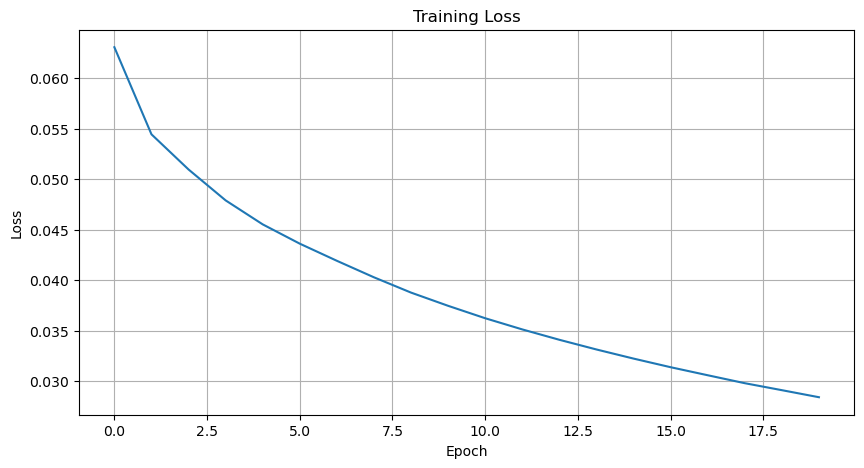

Final loss: 0.0284


In [19]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print(f"Final loss: {history.history['loss'][-1]:.4f}")

In [20]:
# Build Binary Database (if hashing enabled)
if USE_BINARY_HASHING:
    print("\n" + "="*70)
    print("BUILDING BINARY DESCRIPTOR DATABASE")
    print("="*70 + "\n")
    
    # Step 1: Build separate float model (without hashing)
    print("Creating float model for re-ranking...")
    netvlad_float_model = build_netvlad_model_with_hashing(
        BACKBONE, NUM_CLUSTERS, use_hashing=False
    )
    
    # Step 2: Copy trained weights from binary model to float model
    # (excluding the binary hashing layer)
    print("Copying trained weights from binary model...")
    
    for float_layer in netvlad_float_model.layers:
        # Find matching layer in trained model
        for trained_layer in netvlad_model.layers:
            if float_layer.name == trained_layer.name:
                try:
                    float_layer.set_weights(trained_layer.get_weights())
                    print(f"  ✓ Copied weights: {float_layer.name}")
                except Exception as e:
                    print(f"  ⚠ Skipped {float_layer.name}: {e}")
                break
    
    # Step 3: Extract binary codes from binary model
    print("\nExtracting binary codes for training images...")
    train_binary_codes = []
    
    for idx, row in train_df.iterrows():
        img_path = os.path.join('images', row['filename'])
        img = preprocess_image(img_path)
        img = np.expand_dims(img, 0)
        
        # Extract from BINARY model (outputs hash codes)
        binary_code = netvlad_model.predict(img, verbose=0)[0]
        train_binary_codes.append(binary_code)
        
        if (idx + 1) % 10 == 0:
            print(f"  Processed {idx + 1}/{len(train_df)}")
    
    train_binary_codes = np.array(train_binary_codes)
    
    # Convert to packed format: {-1, +1} → {0, 1} uint8
    train_binary_codes_packed = ((train_binary_codes + 1) / 2).astype(np.uint8)
    
    print(f"\n✓ Binary descriptor database built")
    print(f"  Shape: {train_binary_codes.shape}")
    print(f"  Storage: {train_binary_codes_packed.nbytes / 1024:.2f} KB")
    
    # Step 4: Extract float descriptors from float model for re-ranking
    print("\nExtracting float descriptors for re-ranking...")
    
    train_float_descriptors = []
    train_filenames = []
    train_coordinates = []
    
    for idx, row in train_df.iterrows():
        img_path = os.path.join('images', row['filename'])
        img = preprocess_image(img_path)
        img = np.expand_dims(img, 0)
        
        # Extract from FLOAT model (outputs NetVLAD descriptors)
        descriptor = netvlad_float_model.predict(img, verbose=0)[0]
        descriptor = descriptor / (np.linalg.norm(descriptor) + 1e-8)  # L2 normalize
        
        train_float_descriptors.append(descriptor)
        train_filenames.append(row['filename'])
        train_coordinates.append((row['latitude'], row['longitude']))
        
        if (idx + 1) % 10 == 0:
            print(f"  Processed {idx + 1}/{len(train_df)}")
    
    train_float_descriptors = np.array(train_float_descriptors)
    
    print(f"\n✓ Float descriptors for re-ranking built")
    print(f"  Shape: {train_float_descriptors.shape}")
    
else:
    print("Binary hashing disabled, using float descriptors only")


BUILDING BINARY DESCRIPTOR DATABASE

Creating float model for re-ranking...

Model: mobilenetv3small + NetVLAD(64)
  Output dimension: 36864
Trainable params: 73,792
Copying trained weights from binary model...
  ✓ Copied weights: MobileNetV3Small
  ✓ Copied weights: netvlad

Extracting binary codes for training images...
  Processed 10/1757
  Processed 20/1757
  Processed 30/1757
  Processed 40/1757
  Processed 50/1757
  Processed 60/1757
  Processed 70/1757
  Processed 80/1757
  Processed 90/1757
  Processed 100/1757
  Processed 110/1757
  Processed 120/1757
  Processed 130/1757
  Processed 140/1757
  Processed 150/1757
  Processed 160/1757
  Processed 170/1757
  Processed 180/1757
  Processed 190/1757
  Processed 200/1757
  Processed 210/1757
  Processed 220/1757
  Processed 230/1757
  Processed 240/1757
  Processed 250/1757
  Processed 260/1757
  Processed 270/1757
  Processed 280/1757
  Processed 290/1757
  Processed 300/1757
  Processed 310/1757
  Processed 320/1757
  Processed 

In [21]:
def localize_image(img_path, k=5, use_binary=USE_BINARY_HASHING, rerank_top_n=50):
    img = preprocess_image(img_path)
    img = np.expand_dims(img, 0)
    
    if use_binary and USE_BINARY_HASHING:
        # Stage 1: Binary search
        binary_code = netvlad_model.predict(img, verbose=0)[0]
        
        # Hamming distance (count differing bits)
        hamming_distances = np.sum(train_binary_codes != binary_code, axis=1)
        top_n_indices = np.argsort(hamming_distances)[:rerank_top_n]
        
        # Stage 2: Float re-ranking
        query_float = netvlad_float_model.predict(img, verbose=0)[0]
        query_float = query_float / (np.linalg.norm(query_float) + 1e-8)
        
        candidate_descriptors = train_float_descriptors[top_n_indices]
        similarities = np.dot(candidate_descriptors, query_float)
        
        top_k_in_candidates = np.argsort(similarities)[::-1][:k]
        top_k_indices = top_n_indices[top_k_in_candidates]
        top_k_similarities = similarities[top_k_in_candidates]
        
    else:
        # Standard float search
        descriptor = netvlad_model.predict(img, verbose=0)[0]
        descriptor = descriptor / (np.linalg.norm(descriptor) + 1e-8)
        
        similarities = np.dot(train_descriptors, descriptor)
        top_k_indices = np.argsort(similarities)[::-1][:k]
        top_k_similarities = similarities[top_k_indices]
    
    # Build results
    results = []
    for idx, sim in zip(top_k_indices, top_k_similarities):
        results.append((
            train_filenames[idx],
            train_coordinates[idx],
            sim
        ))
    
    pred_coords = train_coordinates[top_k_indices[0]]
    
    return pred_coords, results

print("✓ Localization function defined (with binary search support)")

✓ Localization function defined (with binary search support)


In [22]:
if not USE_BINARY_HASHING:
    # Extract descriptors for training images
    print("Extracting descriptors for training images...")

    train_descriptors = []
    train_filenames = []
    train_coordinates = []

    for idx, row in train_df.iterrows():
        img_path = os.path.join('images', row['filename'])
        img = preprocess_image(img_path)
        img = np.expand_dims(img, 0)
        
        descriptor = netvlad_model.predict(img, verbose=0)[0]
        
        train_descriptors.append(descriptor)
        train_filenames.append(row['filename'])
        train_coordinates.append((row['latitude'], row['longitude']))
        
        if (idx + 1) % 10 == 0:
            print(f"  Processed {idx + 1}/{len(train_df)}")

    train_descriptors = np.array(train_descriptors)

    # Normalize
    train_descriptors = train_descriptors / (np.linalg.norm(train_descriptors, axis=1, keepdims=True) + 1e-8)

    print(f"\n✓ Descriptor database built")
    print(f"  Shape: {train_descriptors.shape}")

## 8. Evaluation

In [23]:
# Evaluate on test set
print("Evaluating on test set...\n")

def haversine_distance_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

predictions = []
ground_truths = []
errors_m = []

for idx, row in test_df.iterrows():
    img_path = os.path.join('images', row['filename'])
    gt_coords = (row['latitude'], row['longitude'])
    
    pred_coords, top_k = localize_image(img_path, k=10)
    
    predictions.append(top_k)
    ground_truths.append(gt_coords)
    
    error_km = haversine_distance_km(
        gt_coords[0], gt_coords[1],
        pred_coords[0], pred_coords[1]
    )
    errors_m.append(error_km * 1000)

errors_m = np.array(errors_m)

print(f"✓ Evaluated {len(test_df)} test images")

Evaluating on test set...

✓ Evaluated 81 test images


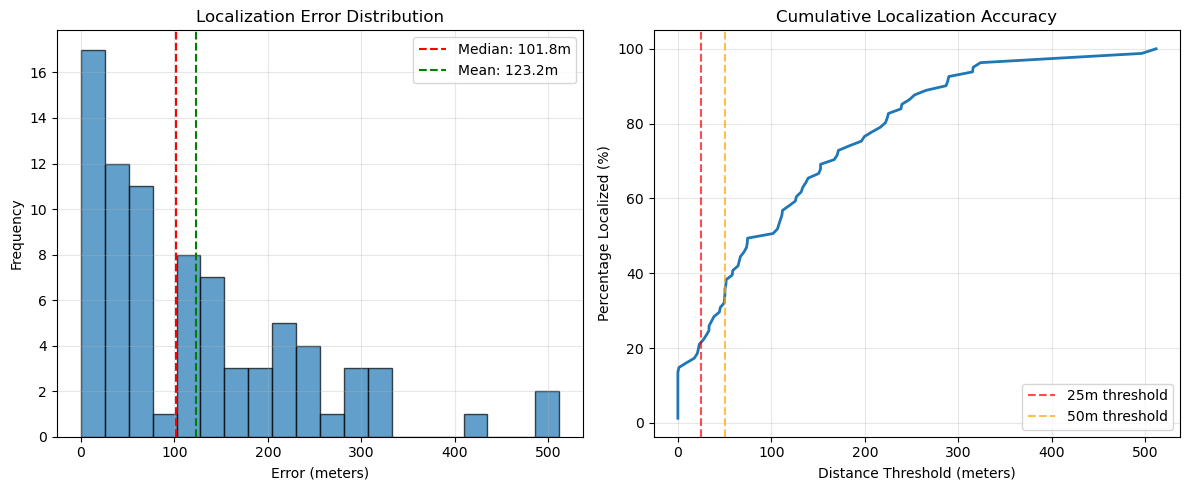

In [24]:
# Visualize error distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors_m, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(np.median(errors_m), color='r', linestyle='--', label=f'Median: {np.median(errors_m):.1f}m')
plt.axvline(np.mean(errors_m), color='g', linestyle='--', label=f'Mean: {np.mean(errors_m):.1f}m')
plt.xlabel('Error (meters)')
plt.ylabel('Frequency')
plt.title('Localization Error Distribution')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sorted_errors = np.sort(errors_m)
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
plt.plot(sorted_errors, cumulative, linewidth=2)
plt.axvline(25, color='r', linestyle='--', alpha=0.7, label='25m threshold')
plt.axvline(50, color='orange', linestyle='--', alpha=0.7, label='50m threshold')
plt.xlabel('Distance Threshold (meters)')
plt.ylabel('Percentage Localized (%)')
plt.title('Cumulative Localization Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
def compute_recall(predictions, ground_truths, k, distance_threshold_m):
    correct = 0
    for pred_list, gt_coords in zip(predictions, ground_truths):
        top_k = pred_list[:k]
        for _, pred_coords, _ in top_k:
            dist_km = haversine_distance_km(
                gt_coords[0], gt_coords[1],
                pred_coords[0], pred_coords[1]
            )
            if dist_km * 1000 <= distance_threshold_m:
                correct += 1
                break
    return correct / len(predictions) if len(predictions) > 0 else 0.0

In [26]:
# Save trained model
model_filename = f'netvlad_{BACKBONE}{"_binary" if USE_BINARY_HASHING else ""}.keras'
netvlad_model.save(model_filename)
print(f"✓ Model saved: {model_filename}")

# Save descriptor database
database_filename = f'train_database_{BACKBONE}{"_binary" if USE_BINARY_HASHING else ""}.npz'

if USE_BINARY_HASHING:
    np.savez(
        database_filename,
        binary_codes=train_binary_codes_packed,
        float_descriptors=train_float_descriptors,
        filenames=np.array(train_filenames, dtype=object),
        coordinates=np.array(train_coordinates, dtype=object),
        hash_bits=HASH_BITS
    )
    print(f"✓ Binary database saved: {database_filename}")
    print(f"  Binary codes: {train_binary_codes_packed.nbytes / 1024:.2f} KB")
    print(f"  Float descriptors: {train_float_descriptors.nbytes / 1024:.2f} KB")
else:
    np.savez(
        database_filename,
        descriptors=train_descriptors,
        filenames=np.array(train_filenames, dtype=object),
        coordinates=np.array(train_coordinates, dtype=object)
    )
    print(f"✓ Database saved: {database_filename}")

# Save results
import json

results = {
    'backbone': BACKBONE,
    'epochs': EPOCHS,
    'binary_hashing': USE_BINARY_HASHING,
    'hash_bits': HASH_BITS if USE_BINARY_HASHING else None,
    'final_loss': float(history.history['loss'][-1]),
    'recall_metrics': {
        f'Recall@{k}_{t}m': float(compute_recall(predictions, ground_truths, k, t))
        for k in [1, 5]
        for t in [10, 25, 50]
    },
    'error_statistics': {
        'mean_m': float(np.mean(errors_m)),
        'median_m': float(np.median(errors_m)),
        'min_m': float(np.min(errors_m)),
        'max_m': float(np.max(errors_m)),
        'std_m': float(np.std(errors_m))
    }
}

with open(f'results_{BACKBONE}.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Results saved: results_{BACKBONE}.json")

✓ Model saved: netvlad_mobilenetv3small_binary.keras
✓ Binary database saved: train_database_mobilenetv3small_binary.npz
  Binary codes: 878.50 KB
  Float descriptors: 253008.00 KB
✓ Results saved: results_mobilenetv3small.json


In [27]:
# Export for Zone Package (ONNX + Binary DB + Metadata)
print("\n" + "="*70)
print("ZONE PACKAGE EXPORT")
print("="*70 + "\n")

try:
    import tf2onnx
    from pathlib import Path
    
    # Determine which model to export (float version for zone package)
    if USE_BINARY_HASHING:
        # Export the float model (without hashing) for zone package
        export_model = netvlad_float_model
        descriptors_to_export = train_float_descriptors
        print("Exporting float model (without binary hashing) for zone package...")
    else:
        export_model = netvlad_model
        descriptors_to_export = train_descriptors
        print("Exporting model for zone package...")
    
    # File paths
    onnx_path = Path(f"weights_{BACKBONE}.onnx")
    db_bin_path = Path(f"database_{BACKBONE}.bin")
    db_index_path = Path(f"database_{BACKBONE}_index.json")
    metadata_path = Path(f"metadata_{BACKBONE}.json")
    
    # 1) Export Keras -> ONNX
    _, H, W, C = export_model.input_shape
    assert C == 3, f"Expected 3 channels, got {C}"
    INPUT_SIZE = H  # typically 224
    print(f"Using inferred input size: {INPUT_SIZE}x{INPUT_SIZE}x{C}")
    
    onnx_model, _ = tf2onnx.convert.from_keras(
        export_model,
        input_signature=[tf.TensorSpec([None, INPUT_SIZE, INPUT_SIZE, 3], tf.float32, name="input")],
        output_path=str(onnx_path)
    )
    print(f"✓ ONNX saved: {onnx_path}")
    
    # 2) Write descriptors to binary + JSON index
    descriptors = np.asarray(descriptors_to_export, dtype=np.float32)  # shape (N, D)
    descriptors.tofile(db_bin_path)
    print(f"✓ DB binary saved: {db_bin_path} shape={descriptors.shape} dtype=float32")
    
    index = []
    for i, (fname, coord) in enumerate(zip(train_filenames, train_coordinates)):
        # coord assumed (lat, lon)
        lat, lon = float(coord[0]), float(coord[1])
        index.append({
            "row": int(i),
            "file": str(fname),
            "lat": lat,
            "lon": lon
        })
    with open(db_index_path, "w", encoding="utf-8") as f:
        json.dump(index, f, indent=2)
    print(f"✓ DB index saved: {db_index_path}")
    
    # 3) Metadata.json
    descriptor_dim = descriptors.shape[1]
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    metadata = {
        "id": f"netvlad-{BACKBONE}",
        "version": "1.0.0",
        "arch": "netvlad",
        "engine": "onnx",
        "input_size": INPUT_SIZE,
        "mean": mean,
        "std": std,
        "center_crop": True,
        "descriptor_dim": int(descriptor_dim),
        "database": {
            "file": db_bin_path.name,
            "index": db_index_path.name,
            "dtype": "float32",
            "metric": "cosine"
        }
    }
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Metadata saved: {metadata_path}")
    
    print("\n✓ Zone package export complete!")
    print(f"  Files: {onnx_path.name}, {db_bin_path.name}, {db_index_path.name}, {metadata_path.name}")
    
except ImportError:
    print("⚠ tf2onnx not installed. Skipping ONNX export.")
    print("  To enable: pip install tf2onnx")
except Exception as e:
    print(f"⚠ Zone package export failed: {e}")


ZONE PACKAGE EXPORT

Exporting float model (without binary hashing) for zone package...
Using inferred input size: 224x224x3


I0000 00:00:1767359407.017386   15451 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2026-01-02 13:10:07.017551: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2026-01-02 13:10:07.029004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 900 MB memory:  -> device: 0, name: NVIDIA H100 NVL, pci bus id: 0000:ca:00.0, compute capability: 9.0
2026-01-02 13:10:07.030240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 92489 MB memory:  -> device: 1, name: NVIDIA H100 NVL, pci bus id: 0000:e1:00.0, compute capability: 9.0
2026-01-02 13:10:10.049813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 900 MB memory:  -> device: 0, name: NVIDIA H100 NVL, pci bus id: 0000:ca:00.0, compute capability: 9.0
2026-0

✓ ONNX saved: weights_mobilenetv3small.onnx
✓ DB binary saved: database_mobilenetv3small.bin shape=(1757, 36864) dtype=float32
✓ DB index saved: database_mobilenetv3small_index.json
✓ Metadata saved: metadata_mobilenetv3small.json

✓ Zone package export complete!
  Files: weights_mobilenetv3small.onnx, database_mobilenetv3small.bin, database_mobilenetv3small_index.json, metadata_mobilenetv3small.json


In [28]:
# Mobile Deployment Summary
print("\n" + "="*70)
print("MOBILE DEPLOYMENT SUMMARY")
print("="*70 + "\n")

print("Generated Files:")
print("-" * 70)

# List all files
suffix = "_binary" if USE_BINARY_HASHING else ""

model_files = [
    f'netvlad_{BACKBONE}{suffix}.h5',
    f'netvlad_{BACKBONE}{suffix}_float32.tflite',
    f'netvlad_{BACKBONE}{suffix}_int8.tflite',
    f'netvlad_{BACKBONE}{suffix}_dynamic.tflite',
]

for fname in model_files:
    if os.path.exists(fname):
        size_kb = os.path.getsize(fname) / 1024
        print(f"✓ {fname:<55} {size_kb:>10.2f} KB")

db_files = [
    f'train_database_{BACKBONE}{suffix}.npz',
]

print()
for fname in db_files:
    if os.path.exists(fname):
        size_kb = os.path.getsize(fname) / 1024
        print(f"✓ {fname:<55} {size_kb:>10.2f} KB")

print("\n" + "="*70)
print("RECOMMENDED DEPLOYMENT OPTIONS")
print("="*70 + "\n")

print("Option 1: Maximum Accuracy (Float32)")
print(f"  Model:    netvlad_{BACKBONE}{suffix}_float32.tflite")
print(f"  Database: train_database_{BACKBONE}{suffix}.npz")
print(f"  Use case: Highest accuracy, larger size")
print()

print("Option 2: Balanced (INT8 Quantization) - RECOMMENDED")
print(f"  Model:    netvlad_{BACKBONE}{suffix}_int8.tflite")
print(f"  Database: train_database_{BACKBONE}{suffix}.npz")
print(f"  Use case: Best balance of size, speed, and accuracy")
print()

if USE_BINARY_HASHING:
    print("Option 3: Maximum Speed (Binary Hashing)")
    print(f"  Model:    netvlad_{BACKBONE}{suffix}.h5")
    print(f"  Database: train_database_{BACKBONE}{suffix}.npz (binary codes)")
    print(f"  Search:   Two-stage (binary + float re-rank)")
    print(f"  Use case: Fastest search with minimal accuracy loss")
    print()

print("="*70)

# Compression stats
if os.path.exists(f'netvlad_{BACKBONE}{suffix}.h5'):
    h5_size = os.path.getsize(f'netvlad_{BACKBONE}{suffix}.h5') / 1024
    
    if os.path.exists(f'netvlad_{BACKBONE}{suffix}_int8.tflite'):
        int8_size = os.path.getsize(f'netvlad_{BACKBONE}{suffix}_int8.tflite') / 1024
        print(f"\nModel Compression (H5 → INT8): {h5_size / int8_size:.2f}x")
    elif os.path.exists(f'netvlad_{BACKBONE}{suffix}_dynamic.tflite'):
        dynamic_size = os.path.getsize(f'netvlad_{BACKBONE}{suffix}_dynamic.tflite') / 1024
        print(f"\nModel Compression (H5 → Dynamic): {h5_size / dynamic_size:.2f}x")

if USE_BINARY_HASHING:
    float_db_size = train_float_descriptors.nbytes / 1024
    binary_db_size = train_binary_codes_packed.nbytes / 1024
    print(f"Database Compression (Float → Binary): {float_db_size / binary_db_size:.2f}x")
    print(f"  Binary codes: {binary_db_size:.2f} KB ({train_binary_codes_packed.nbytes / len(train_df):.1f} bytes/image)")
    print(f"  Float descriptors: {float_db_size:.2f} KB (for re-ranking)")

print("\n" + "="*70)


MOBILE DEPLOYMENT SUMMARY

Generated Files:
----------------------------------------------------------------------

✓ train_database_mobilenetv3small_binary.npz               253961.30 KB

RECOMMENDED DEPLOYMENT OPTIONS

Option 1: Maximum Accuracy (Float32)
  Model:    netvlad_mobilenetv3small_binary_float32.tflite
  Database: train_database_mobilenetv3small_binary.npz
  Use case: Highest accuracy, larger size

Option 2: Balanced (INT8 Quantization) - RECOMMENDED
  Model:    netvlad_mobilenetv3small_binary_int8.tflite
  Database: train_database_mobilenetv3small_binary.npz
  Use case: Best balance of size, speed, and accuracy

Option 3: Maximum Speed (Binary Hashing)
  Model:    netvlad_mobilenetv3small_binary.h5
  Database: train_database_mobilenetv3small_binary.npz (binary codes)
  Search:   Two-stage (binary + float re-rank)
  Use case: Fastest search with minimal accuracy loss

Database Compression (Float → Binary): 288.00x
  Binary codes: 878.50 KB (512.0 bytes/image)
  Float desc

In [29]:
# TFLite Model Validation
print("\n" + "="*70)
print("TFLITE MODEL VALIDATION")
print("="*70 + "\n")

def test_tflite_model(tflite_path, model_name, num_test_images=10):
    """Test TFLite model accuracy and speed."""
    
    if not os.path.exists(tflite_path):
        print(f"⚠ {tflite_path} not found, skipping...")
        return None
    
    # Load interpreter
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print(f"\nTesting {model_name}:")
    print(f"  Input: {input_details[0]['shape']} ({input_details[0]['dtype']})")
    print(f"  Output: {output_details[0]['shape']} ({output_details[0]['dtype']})")
    
    # Test on sample images
    errors = []
    inference_times = []
    
    for idx in range(min(num_test_images, len(test_df))):
        img_path = os.path.join('images', test_df.iloc[idx]['filename'])
        img = preprocess_image(img_path)
        
        # Keras inference
        img_keras = np.expand_dims(img, 0)
        keras_desc = netvlad_model.predict(img_keras, verbose=0)[0]
        
        # TFLite inference
        img_tflite = np.expand_dims(img, 0).astype(input_details[0]['dtype'])
        
        # Handle uint8 quantization
        if input_details[0]['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details[0]['quantization']
            img_tflite = (img_tflite / input_scale + input_zero_point).astype(np.uint8)
        
        interpreter.set_tensor(input_details[0]['index'], img_tflite)
        
        import time
        start = time.time()
        interpreter.invoke()
        inference_time = (time.time() - start) * 1000
        inference_times.append(inference_time)
        
        tflite_desc = interpreter.get_tensor(output_details[0]['index'])[0]
        
        # Normalize (if float output)
        if output_details[0]['dtype'] != np.int8:
            tflite_desc = tflite_desc / (np.linalg.norm(tflite_desc) + 1e-8)
        
        # Compare
        error = np.linalg.norm(keras_desc - tflite_desc)
        errors.append(error)
    
    avg_error = np.mean(errors)
    avg_inference_time = np.mean(inference_times)
    
    print(f"  Descriptor error: {avg_error:.6f}")
    print(f"  Inference time: {avg_inference_time:.2f} ms")
    
    return {'error': avg_error, 'inference_time': avg_inference_time}

# Test all models
results_tflite = {}
suffix = "_binary" if USE_BINARY_HASHING else ""

results_tflite['float32'] = test_tflite_model(f'netvlad_{BACKBONE}{suffix}_float32.tflite', 'Float32')

if os.path.exists(f'netvlad_{BACKBONE}{suffix}_int8.tflite'):
    results_tflite['int8'] = test_tflite_model(f'netvlad_{BACKBONE}{suffix}_int8.tflite', 'INT8')
elif os.path.exists(f'netvlad_{BACKBONE}{suffix}_dynamic.tflite'):
    results_tflite['dynamic'] = test_tflite_model(f'netvlad_{BACKBONE}{suffix}_dynamic.tflite', 'Dynamic')

print("\n✓ TFLite validation complete!")


TFLITE MODEL VALIDATION

⚠ netvlad_mobilenetv3small_binary_float32.tflite not found, skipping...

✓ TFLite validation complete!


In [30]:
# TFLite Conversion with INT8 Quantization
print("\n" + "="*70)
print("TFLITE CONVERSION AND QUANTIZATION")
print("="*70 + "\n")

# Representative dataset for INT8 calibration
def representative_dataset_gen():
    """Generate calibration samples for INT8 quantization."""
    num_calibration_samples = min(100, len(train_df))
    
    for idx in range(num_calibration_samples):
        img_path = os.path.join('images', train_df.iloc[idx]['filename'])
        img = preprocess_image(img_path)
        img = np.expand_dims(img, 0).astype(np.float32)
        yield [img]

# 1. Convert to Float32 TFLite
print("Converting to TFLite (Float32)...")
converter_float = tf.lite.TFLiteConverter.from_keras_model(netvlad_model)
converter_float.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_float_model = converter_float.convert()

float_model_path = f'netvlad_{BACKBONE}{"_binary" if USE_BINARY_HASHING else ""}_float32.tflite'
with open(float_model_path, 'wb') as f:
    f.write(tflite_float_model)

print(f"✓ Float32 TFLite: {float_model_path}")
print(f"  Size: {len(tflite_float_model) / 1024:.2f} KB")

# 2. Convert to INT8 TFLite
print("\nConverting to TFLite (INT8)...")
converter_int8 = tf.lite.TFLiteConverter.from_keras_model(netvlad_model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_dataset_gen

# Full integer quantization
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.uint8
converter_int8.inference_output_type = tf.float32  # Keep descriptor as float

try:
    tflite_int8_model = converter_int8.convert()
    
    int8_model_path = f'netvlad_{BACKBONE}{"_binary" if USE_BINARY_HASHING else ""}_int8.tflite'
    with open(int8_model_path, 'wb') as f:
        f.write(tflite_int8_model)
    
    print(f"✓ INT8 TFLite: {int8_model_path}")
    print(f"  Size: {len(tflite_int8_model) / 1024:.2f} KB")
    print(f"  Compression: {len(tflite_float_model) / len(tflite_int8_model):.2f}x")
    
except Exception as e:
    print(f"⚠ INT8 conversion failed: {e}")
    print("  Falling back to dynamic range quantization...")
    
    # Fallback: Dynamic range (weights only)
    converter_dr = tf.lite.TFLiteConverter.from_keras_model(netvlad_model)
    converter_dr.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_dr_model = converter_dr.convert()
    
    dr_model_path = f'netvlad_{BACKBONE}{"_binary" if USE_BINARY_HASHING else ""}_dynamic.tflite'
    with open(dr_model_path, 'wb') as f:
        f.write(tflite_dr_model)
    
    print(f"✓ Dynamic range TFLite: {dr_model_path}")
    print(f"  Size: {len(tflite_dr_model) / 1024:.2f} KB")

print("\n✓ TFLite conversion complete!")


TFLITE CONVERSION AND QUANTIZATION

Converting to TFLite (Float32)...
INFO:tensorflow:Assets written to: /tmp/tmp9721kzz5/assets


INFO:tensorflow:Assets written to: /tmp/tmp9721kzz5/assets


Saved artifact at '/tmp/tmp9721kzz5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 512), dtype=tf.float32, name=None)
Captures:
  140723193573840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193575184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193573648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193574416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193574800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193573072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193572112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193574992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193574608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193575568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14073690

W0000 00:00:1767359460.211987   15451 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1767359460.212011   15451 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2026-01-02 13:11:00.212520: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9721kzz5
2026-01-02 13:11:00.221090: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2026-01-02 13:11:00.221111: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp9721kzz5
2026-01-02 13:11:00.324252: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2026-01-02 13:11:00.924569: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp9721kzz5
2026-01-02 13:11:01.085626: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 873109 microseconds.


✓ Float32 TFLite: netvlad_mobilenetv3small_binary_float32.tflite
  Size: 19769.73 KB

Converting to TFLite (INT8)...
INFO:tensorflow:Assets written to: /tmp/tmp4vmvzife/assets


INFO:tensorflow:Assets written to: /tmp/tmp4vmvzife/assets


Saved artifact at '/tmp/tmp4vmvzife'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 512), dtype=tf.float32, name=None)
Captures:
  140723193573840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193575184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193573648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193574416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193574800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193573072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193572112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193574992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193574608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140723193575568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14073690

/opt/conda/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1767359480.739922   15451 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1767359480.739946   15451 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2026-01-02 13:11:20.740161: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4vmvzife
2026-01-02 13:11:20.747868: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2026-01-02 13:11:20.747890: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp4vmvzife
2026-01-02 13:11:20.850303: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2026-01-02 13:11:21.421108: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp4vmvzife
2026

✓ INT8 TFLite: netvlad_mobilenetv3small_binary_int8.tflite
  Size: 19788.20 KB
  Compression: 1.00x

✓ TFLite conversion complete!


## 11. Mobile Deployment: TFLite Conversion

## 9. Save and Download Results

In [ ]:
# Save trained model
model_filename = f'netvlad_{BACKBONE}.h5'
netvlad_model.save(model_filename)
print(f"✓ Model saved: {model_filename}")

# Save descriptor database
database_filename = f'train_database_{BACKBONE}.npz'
np.savez(
    database_filename,
    descriptors=train_descriptors,
    filenames=np.array(train_filenames, dtype=object),
    coordinates=np.array(train_coordinates, dtype=object)
)
print(f"✓ Database saved: {database_filename}")

# Save results
import json

results = {
    'backbone': BACKBONE,
    'epochs': EPOCHS,
    'final_loss': float(history.history['loss'][-1]),
    'recall_metrics': {
        f'Recall@{k}_{t}m': float(compute_recall(predictions, ground_truths, k, t))
        for k in [1, 5]
        for t in [10, 25, 50]
    },
    'error_statistics': {
        'mean_m': float(np.mean(errors_m)),
        'median_m': float(np.median(errors_m)),
        'min_m': float(np.min(errors_m)),
        'max_m': float(np.max(errors_m)),
        'std_m': float(np.std(errors_m))
    }
}

with open(f'results_{BACKBONE}.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Results saved: results_{BACKBONE}.json")

In [ ]:
# Download files (for Colab)
if IN_COLAB:
    print("Downloading files...")
    files.download(model_filename)
    files.download(database_filename)
    files.download(f'results_{BACKBONE}.json')
    print("✓ Files downloaded")
else:
    print("Files saved in current directory")
    print(f"  Model: {model_filename}")
    print(f"  Database: {database_filename}")
    print(f"  Results: results_{BACKBONE}.json")

## 10. Test Single Image (Optional)

In [31]:
# Test on a single image
test_image = test_df.iloc[0]
test_img_path = os.path.join('images', test_image['filename'])
gt_coords = (test_image['latitude'], test_image['longitude'])

print(f"Query image: {test_image['filename']}")
print(f"Ground truth: ({gt_coords[0]:.6f}, {gt_coords[1]:.6f})")
print()

pred_coords, top_5 = localize_image(test_img_path, k=5)

print(f"Predicted: ({pred_coords[0]:.6f}, {pred_coords[1]:.6f})")
error_km = haversine_distance_km(
    gt_coords[0], gt_coords[1],
    pred_coords[0], pred_coords[1]
)
print(f"Error: {error_km * 1000:.2f} meters")
print()

print("Top-5 matches:")
for i, (fname, coords, sim) in enumerate(top_5, 1):
    dist_km = haversine_distance_km(gt_coords[0], gt_coords[1], coords[0], coords[1])
    status = "✓" if dist_km * 1000 <= 25 else "✗"
    print(f"{i}. {fname}: {sim:.4f} | {dist_km*1000:.1f}m {status}")

Query image: 100.jpg
Ground truth: (54.906279, 23.956114)

Predicted: (54.905261, 23.957172)
Error: 131.91 meters

Top-5 matches:
1. 56.jpg: 0.9559 | 131.9m ✗
2. 39.jpg: 0.9539 | 196.3m ✗
3. 35.jpg: 0.9516 | 195.9m ✗
4. 93.jpg: 0.9431 | 58.7m ✗
5. 49.jpg: 0.9376 | 183.5m ✗


## Summary

Training complete! You have:
1. ✓ Trained NetVLAD model
2. ✓ Built descriptor database
3. ✓ Evaluated on test set
4. ✓ Saved model and results

**Files created:**
- `netvlad_{backbone}.h5` - Trained model
- `train_database_{backbone}.npz` - Descriptor database
- `results_{backbone}.json` - Evaluation metrics

**Next steps:**
- Try training with ResNet50 for better accuracy
- Experiment with different hyperparameters
- Test on your own images